In [1]:
import numpy as np
import scipy.sparse
import scipy
import pandas as pd
import re
import math
from datetime import datetime, date, timedelta

import sqlalchemy as sa
from sqlalchemy.types import Integer, Float, Date, VARCHAR

import keras
from keras.models import Sequential,model_from_json
from keras.layers import Dense, LSTM, GRU, Activation, Masking, BatchNormalization, Lambda, GaussianDropout
from keras.layers.wrappers import TimeDistributed
from keras import backend as k
from keras import callbacks
from keras.optimizers import RMSprop, Adam
from keras.callbacks import History
from keras import regularizers

import sklearn
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from category_encoders import CatBoostEncoder

from six.moves import xrange
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import wtte.weibull as weibull
import wtte.wtte as wtte
from wtte.wtte import WeightWatcher
import wtte.transforms as tr
import lifelines
import warnings
warnings.filterwarnings("ignore")

pd.options.display.min_rows = 1000
pd.options.display.max_rows = 800
pd.options.display.max_columns = 50

Using TensorFlow backend.


In [2]:
datalab_auth = ('SHINKAREV_DA[PxU_DCBUL_UMA_MOD]', 'dSH_19848+++', 'DATALAB')

In [4]:
# дата прогноза
#ddate = datetime.date(2022,6,30)
ddate = date(2023,1,31)

In [5]:
def read_sql_table(auth_data, table_name):
    login, password, tns = auth_data[0], auth_data[1], auth_data[2]
    conn_str = 'oracle+cx_oracle://' + login + ':' + password + '@' + tns
    oracle_db = sa.create_engine(conn_str, encoding= 'utf-8', max_identifier_length=128)
    
    connection = oracle_db.connect()
    table = pd.read_sql_table(table_name, connection)
    connection.close()
    
    return table

In [6]:
def clean_inn(inn):
    inn = str(inn).strip()
    if re.search(r'\D', inn):
        return np.nan
    
    if len(inn) == 12 and inn[:2] == '00':
        inn = inn[2:]

    digits = [int(x) for x in inn]
    if len(digits) == 12: # проверка для ИП и ФЛ
        coeff1 = [7, 2, 4, 10, 3, 5, 9, 4, 6, 8]
        checksum1 = sum([x * digits[i] for i, x in enumerate(coeff1)]) % 11 % 10
        coeff2 = [3, 7, 2, 4, 10, 3, 5, 9, 4, 6, 8]
        checksum2 = sum([x * digits[i] for i, x in enumerate(coeff2)]) % 11 % 10

        if checksum1 == digits[-2] and checksum2 == digits[-1]:
            return inn
        else:
            return np.nan
    elif len(digits) == 10: # проверка для ЮЛ
        coeff = [2, 4, 10, 3, 5, 9, 4, 6, 8, 0]
        checksum = sum([x * digits[i] for i, x in enumerate(coeff)]) % 11 % 10
        if checksum == digits[-1]:
            return inn
        else:
            return np.nan
    else:
        return np.nan

In [7]:
dataset_orig = read_sql_table(datalab_auth, 'ev_wei_final')

In [8]:
dataset_orig.inn = dataset_orig.inn.apply(clean_inn)
dataset_orig = dataset_orig.dropna(subset=['inn'])
dataset_orig = dataset_orig.loc[dataset_orig.inn !='0000000000', :]

In [9]:
dataset_orig['time'] = dataset_orig.ddate.rank(method='dense').astype(int) # номер периода (месяца)

In [10]:
del dataset_orig['is_ufm']
del dataset_orig['is_liq']

In [11]:
# Выбираем клиентов, у которых были разрывы в обслуживании
'''wrong_clients = dataset_orig.groupby('inn').time.agg(['count', lambda x : x.max() - x.min() + 1])\
                                            .rename(columns={'count' : 'cnt', '<lambda_0>' : 'max_min'})
wrong_clients = wrong_clients.loc[wrong_clients.cnt != wrong_clients.max_min, :]
wrong_clients = wrong_clients.reset_index()
dataset_orig = dataset_orig.loc[~dataset_orig.inn.isin(wrong_clients.inn), :]'''

"wrong_clients = dataset_orig.groupby('inn').time.agg(['count', lambda x : x.max() - x.min() + 1])                                            .rename(columns={'count' : 'cnt', '<lambda_0>' : 'max_min'})\nwrong_clients = wrong_clients.loc[wrong_clients.cnt != wrong_clients.max_min, :]\nwrong_clients = wrong_clients.reset_index()\ndataset_orig = dataset_orig.loc[~dataset_orig.inn.isin(wrong_clients.inn), :]"

In [12]:
dataset_orig = dataset_orig.reset_index(drop=True)

In [13]:
dataset_orig['t_elapsed'] = dataset_orig.groupby('inn', group_keys=False).apply(lambda g : g.time - g.time.min()) # номер месяца жизни, начиная с 0

In [14]:
dataset_orig['ddate'].max()

Timestamp('2023-01-31 00:00:00')

In [15]:
#from datetime import fromtimestamp
dataset_orig['ddate'] = dataset_orig['ddate'].apply(pd.to_datetime) 

In [16]:
dataset_orig['ddate'] = dataset_orig['ddate'].map(lambda x: x.date())

In [17]:
#удаление заблокированных и ликвидированных
#dataset_orig = dataset_orig[(dataset_orig['is_ufm']!=1) & (dataset_orig['date_liq'].isnull()) ]

In [18]:
predict_period = dataset_orig.ddate.max()

### Заполнение пропусков возраста клиента и компании

In [19]:
def company_age(row):
    d1, d2 = row[0], row[1]
    if pd.notnull(d1) and pd.notnull(d2):
        return max((d1.year - d2.year) * 12 + d1.month - d2.month, 0)
    else:
        return np.nan

In [20]:
ages_df = dataset_orig.groupby('inn').agg({'date_reg' : 'min', 'coming_date' : 'min', 'ddate' : 'min'})
ages_df['start_comp_age'] = ages_df.loc[:, ['ddate', 'date_reg']].apply(company_age, axis=1)
ages_df['start_cust_age'] = ages_df.loc[:, ['ddate', 'coming_date']].apply(company_age, axis=1)

most_freq_start_comp_age = ages_df.start_comp_age.dropna().mode()[0]
ages_df.start_comp_age  = ages_df.start_comp_age.fillna(value=most_freq_start_comp_age)

most_freq_start_cust_age = ages_df.start_cust_age.dropna().mode()[0]
ages_df.start_cust_age = ages_df.start_cust_age.fillna(value=most_freq_start_cust_age)
ages_df = ages_df.drop(columns=['date_reg', 'coming_date', 'ddate'])

dataset_orig = dataset_orig.merge(ages_df, left_on=['inn'], right_index=True)
dataset_orig['comp_age'] = dataset_orig.start_comp_age + dataset_orig.t_elapsed
dataset_orig['cust_age'] = dataset_orig.start_cust_age + dataset_orig.t_elapsed
del ages_df

In [21]:
'''dataset_orig = dataset_orig[dataset_orig.is_arest != 1]
dataset_orig.shape'''

'dataset_orig = dataset_orig[dataset_orig.is_arest != 1]\ndataset_orig.shape'

In [22]:
dataset_orig['ul'] = dataset_orig['inn'].map(lambda x : 1 if len(x)==10 else 0 )

In [23]:
for i in ['deposit', 'credit',
       'cl_status_pay', 'debet', 'nalog', 'count_bank', 'sum_other_bank',
       'count_contr', 'fiz_debet', 'count_trans', 'credit_sum', 'count_bank_c',
       'sum_other_bank_c', 'count_contr_c', 'count_trans_c', 'equar', 'cash',
       'kom_doxod', 'cur_dvs', 'avg_dvs', 'sum_product','ufm','liq']:
    dataset_orig[i] = dataset_orig[i].fillna(0)

In [24]:
dataset_orig['prime_category'] = np.where(dataset_orig['prime_category']=='Малый',1,0)

In [25]:
dataset_orig['id'] = dataset_orig.inn.rank(method='dense').astype(int)
#dataset_mod.id.nunique()

### Выбор переменных, исправление типов переменных и приведение пропусков к одному виду

In [26]:
import datetime
dataset_mod = dataset_orig#[dataset_orig['ddate']< datetime.date(2021,3,31)]
dataset_mod['ddate'].max()

datetime.date(2023, 1, 31)

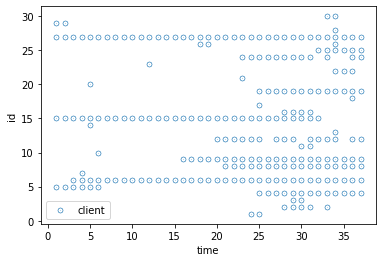

In [27]:
rand_ids = dataset_mod.inn.drop_duplicates().sample(n=30, random_state=1)
rand_d = dataset_mod[dataset_mod.inn.isin(rand_ids)]
rand_d['id'] = rand_d.inn.rank(method='dense').astype('int')
plt.scatter(rand_d.time, rand_d.id, 0.4, label='client',marker = 'o',linewidths = 5)
plt.xlabel('time')
plt.ylabel('id')
# plt.vlines(x=censoring_point,ymin=0,ymax=len(df_subset.id.unique()),color='red',linestyles='dotted',label = 'Censoring point')
plt.legend()
plt.show()

In [28]:
'''dataset_mod['id'] = dataset_mod.inn.rank(method='dense').astype(int)
dataset_mod.id.nunique()'''

"dataset_mod['id'] = dataset_mod.inn.rank(method='dense').astype(int)\ndataset_mod.id.nunique()"

In [29]:
dataset_mod.ddate.max()

datetime.date(2023, 1, 31)

In [30]:
# максимальный номер периода (для обучения выбрать пораньше на неск. месяцев)
max_seq_length = dataset_mod.time.max() - 1
print(max_seq_length)
starttimes_max = max_seq_length
censoring_point = starttimes_max + 1

36


In [31]:
censoring_point

37

In [32]:
  #  если клиент жив на макс. дату, то 0, иначе 1
is_cens = dataset_mod.groupby('inn').time.agg(lambda x : 0 if x.max() >= censoring_point else 1)
is_cens.name = 'cens'
dataset_mod = dataset_mod.merge(is_cens, left_on='inn', right_index=True)

In [33]:
# Для Сережи
# serg_inn = dataset_mod.loc[dataset_mod.per_m > datetime(2019, 8, 1)].inn.drop_duplicates()
# dataset_forecast = dataset_mod.loc[dataset_mod.inn.isin(serg_inn), :]
# dataset_mod = dataset_mod.loc[dataset_mod.time != censoring_point, :]

In [34]:
#dataset_forecast = dataset_mod.loc[dataset_mod.cens == 0, :] # все, кто жив на период (для тестирования)
dataset_mod = dataset_mod.loc[dataset_mod.time < censoring_point, :] # КЛИЕНТЫ для обучения

In [35]:
dataset_mod['tte'] = dataset_mod.groupby('inn', group_keys=False).apply(lambda g : g.t_elapsed.max() - g.t_elapsed)

In [36]:
max_tte = dataset_mod.groupby('inn').apply(lambda g : g.tte.max())
dataset_mod = dataset_mod[dataset_mod.inn.isin(max_tte[max_tte>=0].index)]
dataset_mod.shape

(4897608, 84)

In [37]:
max_cust_age = dataset_mod.groupby('inn').apply(lambda g : g.cust_age.max())

In [38]:
#dataset_mod['liq'] = np.where(dataset_mod['liq'].notna(),1,0)
#dataset_mod['revenue_calc'] = dataset_mod['revenue_calc']/(10**3)

In [39]:
dataset_mod1 = dataset_mod#[(dataset_mod['is_ufm']!=1)&(dataset_mod['date_liq'].isna())]
dataset_mod1.shape,dataset_mod.shape

((4897608, 84), (4897608, 84))

In [40]:
#del dataset_mod

In [41]:
#dataset_mod1 = dataset_mod1[dataset_mod1.inn.isin(max_tte[max_tte>=2].index)]

In [42]:
# распределние живых и мертвых в выборке
is_cens_mod = dataset_mod1.groupby('inn').cens.max()
is_cens_mod.value_counts()

cens_inn = is_cens_mod[(is_cens_mod == 0) ]#& (is_cens_mod.index.isin(part_new.index))]
uncens_inn = is_cens_mod[(is_cens_mod == 1)]# & (is_cens_mod.index.isin(part_new.index))]

In [43]:
# искусственное уменьшение выборки с живыми
#cens_rate = 0.5
#cens_inn = resample(cens_inn, replace=False, n_samples = int(uncens_inn.shape[0] * (1 - cens_rate) / cens_rate))
new_samples = pd.concat([cens_inn, uncens_inn])

In [44]:
#new_samples = pd.concat([new_samples,new_samples[new_samples==1]],axis=0)
new_samples.value_counts()

1    385199
0    143660
Name: cens, dtype: int64

In [45]:
dataset_mod1['sup_manager1'] = np.where(dataset_mod1['sup_manager'].isna(),0,1)

In [46]:
# split data to train and test
train_inns, test_inns = train_test_split(new_samples, train_size=0.8,stratify=new_samples,random_state = 4)

train_dataset_mod = dataset_mod1[dataset_mod1.inn.isin(train_inns.index)]
test_dataset_mod = dataset_mod1[dataset_mod1.inn.isin(test_inns.index)]

In [47]:
# распределние живых и мертвых в выборке
is_cens_mod = train_dataset_mod.groupby('inn').cens.max()
is_cens_mod.value_counts()

1    308159
0    114928
Name: cens, dtype: int64

In [48]:
cens_inn1 = is_cens_mod[(is_cens_mod == 0) ]#& (is_cens_mod.index.isin(part_new.index))]
uncens_inn1 = is_cens_mod[(is_cens_mod == 1)]

In [49]:
# искусственное уменьшение выборки с живыми 
#(если не применять, то почти для всех клиентов будут выдаваться очень большие значения, в итоге медианная ошибка будет большой)

cens_rate = 0.75
cens_inn1 = resample(cens_inn1, replace=False, n_samples = int(uncens_inn1.shape[0] * (1 - cens_rate) / cens_rate))
new = pd.concat([cens_inn1, uncens_inn1])
train_dataset_mod = train_dataset_mod[train_dataset_mod.inn.isin(new.index)]

#### Подготовка выборок

In [50]:
dataset_orig['ddate'] = dataset_orig['ddate'].apply(pd.to_datetime)

dataset_orig['ddate'] = dataset_orig['ddate'].map(lambda x: x.date())

In [51]:
#dataset_orig['liq'] = np.where(dataset_orig['liq'].notna(),1,0)

In [52]:
# выборка для ежемесячного ПРОГНОЗА
test = dataset_orig[(dataset_orig['ddate']<=ddate)]

inn = dataset_orig[(dataset_orig['ddate']==ddate)\
                  #(dataset_orig['cust_age']>=0)&(dataset_orig['ufm']!=1) & (dataset_orig['liq']!=1)
                  ]['inn']
                    

dataset_forecast = test[test['inn'].isin(inn)] # выборка для прогноза

In [53]:
for data in (train_dataset_mod,test_dataset_mod,dataset_forecast):    
    data['cr/db'] = data['credit_sum']/data['debet']
    data['cr/db_contr'] = data['count_contr_c']/data['count_contr']
    data['other_debet'] = data['sum_other_bank']/data['debet']
    data['other_credit'] = data['sum_other_bank_c']/data['credit_sum']
    data['kom/debet'] = data['kom_doxod']/data['debet']
    data['cash_debet'] = data['cash']/data['debet']
    data['debet/dvs'] = data['debet']/data['avg_dvs']
    data['credit+debet'] = data['credit_sum']+data['debet']

In [54]:
#dataset_mod['sup_manager1'] = np.where(dataset_mod['sup_manager'].isna(),0,1)
dataset_forecast['sup_manager1'] = np.where(dataset_forecast['sup_manager'].isna(),0,1)

In [55]:
for data in (train_dataset_mod,test_dataset_mod,dataset_forecast):    
    for j in ['corp_card', 'factoring', 'nkl', 'nso', 'business_prepaid',
       'overdraft', 'depp', 'vkl', 'letter_credit', 'bss', 'inkass', 'pledge',
       'sms', 'ins', 'acc_cur', 'depp_5', 'depp_3', 'convers']:
        data[j] = data[j].fillna(0)

In [56]:
#s = StandardScaler()

id_cols = ['id', 'inn']
time_cols = ['ddate', 'tte', 'cens','t_elapsed']
sum_cols = ['debet', 'nalog','sum_other_bank', 'fiz_debet',
       'credit_sum', 'equar', 'kom_doxod', 'cur_dvs', 'avg_dvs','revenue_calc','cash',#'regular_week',#'regular_month',
           'credit+debet','sum_zp'
           ]
categ_features_cols = ['cl_status_pay']#,'kind_ib,'rko_package']
bin_categ_cols = ['deposit', 'credit','ul','prime_category','other_bank_sber', 'other_bank_vtb',
       'other_bank_alpha', 'other_bank_tinkoff','tax_restrictions','flag_of_strategic_client',
                 'flag_phone_number','flag_phone_mobile','sup_manager1','corp_card','liq','ufm'
                 ,'factoring', 'nkl', 'nso', 'business_prepaid',
       'overdraft', 'depp', 'vkl', 'letter_credit', 'bss', 'inkass', 'pledge',
       'sms', 'ins', 'acc_cur', 'depp_5', 'depp_3', 'convers'
                 ]
order_features_cols = ['comp_age', 'cust_age','count_bank','count_contr','count_trans','count_bank_c', 'sum_other_bank_c',
       'count_contr_c', 'count_trans_c','sum_product','count_company_clients_bank','d_before_defrost_communication']
med = ['distance_of','prob_block','wallet_share','prob_act']
dinam = [ 'cr/db',
       'cr/db_contr', 'other_debet', 'other_credit', 'kom/debet', 'cash_debet',
       'debet/dvs']
#in_tran_cols = ['okved_dop','hub_dop']

#s.fit(train_dataset_mod[num_cols])

In [57]:
dataset_forecast['cens'] = 0
dataset_forecast['tte'] = 0

cols_names = id_cols + time_cols + sum_cols + order_features_cols + bin_categ_cols + categ_features_cols+med +dinam#+ in_tran_cols
# поменять местами
train_dataset_mod = train_dataset_mod.loc[:, cols_names]
test_dataset_mod = test_dataset_mod.loc[:, cols_names]
dataset_forecast = dataset_forecast.loc[:, cols_names]

In [58]:
train_dataset_mod['cl_status_pay'].unique()

array(['Постоянный', 'Периодический', 'Неплатящий', 'Мерцающий'],
      dtype=object)

In [59]:
dic = {'Постоянный' : 0, 'Периодический' : 1, 'Мерцающий' : 2, 'Неплатящий' : 3}
train_dataset_mod['cl_status_pay'] = train_dataset_mod['cl_status_pay'].map(dic)
test_dataset_mod['cl_status_pay'] = test_dataset_mod['cl_status_pay'].map(dic)
dataset_forecast['cl_status_pay'] = dataset_forecast['cl_status_pay'].map(dic)

In [60]:
import warnings
warnings.filterwarnings("ignore")

In [61]:
#__________________

In [62]:
id_cols = ['id', 'inn']
time_cols = ['ddate', 'tte', 'cens','t_elapsed']
cols_names = id_cols + time_cols + sum_cols + order_features_cols + bin_categ_cols + categ_features_cols+med +dinam 
train_dataset_mod = train_dataset_mod.loc[:, cols_names]
test_dataset_mod = test_dataset_mod.loc[:, cols_names]
dataset_forecast = dataset_forecast.loc[:, cols_names]

In [63]:
train_dataset_mod.shape

(3639886, 76)

In [64]:
train_dataset_mod = train_dataset_mod[(train_dataset_mod['cust_age']/12) <= 30]
test_dataset_mod = test_dataset_mod[(test_dataset_mod['cust_age']/12) <= 30]
dataset_forecast = dataset_forecast[(dataset_forecast['cust_age']/12) <= 30]

In [65]:
np.quantile(train_dataset_mod['cust_age']/12,0.9999)

29.083333333333332

In [66]:
train_dataset_mod1 = train_dataset_mod
test_dataset_mod1 = test_dataset_mod
dataset_forecast1 = dataset_forecast

In [67]:
#for data in (train_dataset_mod1,test_dataset_mod1,dataset_forecast1):
'''train_dataset_mod1 = pd.get_dummies(train_dataset_mod1,columns = ['rko_package','cl_status_pay'],drop_first = True)

test_dataset_mod1 = pd.get_dummies(test_dataset_mod1,columns = ['rko_package','cl_status_pay'],drop_first = True)
dataset_forecast1 = pd.get_dummies(dataset_forecast1,columns = ['rko_package','cl_status_pay'],drop_first = True)'''

"train_dataset_mod1 = pd.get_dummies(train_dataset_mod1,columns = ['rko_package','cl_status_pay'],drop_first = True)\n\ntest_dataset_mod1 = pd.get_dummies(test_dataset_mod1,columns = ['rko_package','cl_status_pay'],drop_first = True)\ndataset_forecast1 = pd.get_dummies(dataset_forecast1,columns = ['rko_package','cl_status_pay'],drop_first = True)"

In [68]:
for i in (train_dataset_mod1,test_dataset_mod1,dataset_forecast1):
    i['liq'] = np.where(i['liq']==0,0,1)

In [69]:
'''bin_categ_cols1 = bin_categ_cols + ['rko_package_МСБ. Весь мир', 'rko_package_МСБ. Начни с нуля',
       'rko_package_МСБ. Открытые возможности', 'rko_package_МСБ. Первый шаг',
       'rko_package_МСБ. Свой бизнес', 'rko_package_МСБ.Большие планы',
       'rko_package_МСБ.Общее дело', 'rko_package_РКО', 'rko_package_ЦТС',
       'cl_status_pay_Неплатящий', 'cl_status_pay_Периодический',
       'cl_status_pay_Постоянный']'''

for i in [sum_cols + order_features_cols + bin_categ_cols +med +dinam + categ_features_cols]:
    train_dataset_mod1[i] = train_dataset_mod1[i].astype('float')
    test_dataset_mod1[i] = test_dataset_mod1[i].astype('float')
    dataset_forecast1[i] = dataset_forecast1[i].astype('float')

In [70]:
for i in dinam:
    for j in [train_dataset_mod1,test_dataset_mod1,dataset_forecast1]:
        j[i] = np.where(j[i]==float('inf'),777777777,j[i])
        j[i] = np.where(j[i]==-float('inf'),-777777777,j[i])

In [71]:
column_imput = make_column_transformer(
       (SimpleImputer(strategy='constant'), sum_cols+dinam),
       (SimpleImputer(strategy='median'), med),
      (SimpleImputer(strategy='constant', ), order_features_cols),
      (SimpleImputer(strategy='constant'), categ_features_cols),
     (SimpleImputer(strategy='constant' ), bin_categ_cols),
        remainder='passthrough',
        sparse_threshold=0.3,
        )

In [72]:
id_cols = ['id', 'inn']
time_cols = ['ddate', 'tte', 'cens','t_elapsed']
cols_names =  sum_cols +dinam +med + order_features_cols+ categ_features_cols + bin_categ_cols  + id_cols + time_cols
train_dataset_mod1 = train_dataset_mod1.loc[:, cols_names]
test_dataset_mod1 = test_dataset_mod1.loc[:, cols_names]
dataset_forecast1 = dataset_forecast1.loc[:, cols_names]

In [73]:
train_dataset_mod1 = pd.DataFrame(column_imput.fit_transform(train_dataset_mod1), columns=train_dataset_mod1.columns)

In [74]:
test_dataset_mod1 = pd.DataFrame(column_imput.transform(test_dataset_mod1), columns=test_dataset_mod1.columns)

In [75]:
dataset_forecast1 = pd.DataFrame(column_imput.transform(dataset_forecast1), columns=dataset_forecast1.columns)

In [76]:
main_cont_transformer = Pipeline(steps=[
            ('log', FunctionTransformer(lambda x : np.log(np.abs(x.astype(float)+1)), validate=False)),
            ('scaler', StandardScaler()),
        ])

column_tranform = make_column_transformer(
        (main_cont_transformer, sum_cols),
        (StandardScaler(), order_features_cols+dinam),
        (CatBoostEncoder(), categ_features_cols),
        (OneHotEncoder(drop='if_binary'), bin_categ_cols),
        remainder='passthrough',
        sparse_threshold=0.3,
        )

In [77]:
id_cols = ['id', 'inn']
time_cols = ['ddate', 'tte', 'cens','t_elapsed']
cols_names =  sum_cols+ order_features_cols +dinam  + categ_features_cols + bin_categ_cols  + id_cols + time_cols +med
train_dataset_mod1 = train_dataset_mod1.loc[:, cols_names]
test_dataset_mod1 = test_dataset_mod1.loc[:, cols_names]
dataset_forecast1 = dataset_forecast1.loc[:, cols_names]

In [78]:
def feat_trans_fit_transform(df):
    tte = df.tte
    tmp_matr = column_tranform.fit_transform(df, tte)
    col_names = sum_cols+ order_features_cols +dinam  + categ_features_cols + bin_categ_cols  + id_cols + time_cols +med
    if isinstance(tmp_matr, scipy.sparse.spmatrix):
        tmp_df = pd.DataFrame.sparse.from_spmatrix(tmp_matr, columns=col_names)
    else:
        tmp_df = pd.DataFrame(tmp_matr, columns=col_names)
    return tmp_df

In [79]:
train_dataset_mod1 = feat_trans_fit_transform(train_dataset_mod1)

In [80]:
#del train_dataset_mod2

In [81]:
def feat_trans_transform(df):
    tmp_matr = column_tranform.transform(df)
    col_names = sum_cols+ order_features_cols +dinam  + categ_features_cols + bin_categ_cols  + id_cols + time_cols +med
    if isinstance(tmp_matr, scipy.sparse.spmatrix):
        tmp_df = pd.DataFrame.sparse.from_spmatrix(tmp_matr, columns=col_names)
    else:
        tmp_df = pd.DataFrame(tmp_matr, columns=col_names)
    return tmp_df

In [82]:
test_dataset_mod1 = feat_trans_transform(test_dataset_mod1)

In [83]:
dataset_forecast1 = feat_trans_transform(dataset_forecast1)

### Подготовка модели

In [84]:
tte_mean_train = train_dataset_mod1.tte.mean()
mean_u = train_dataset_mod1.groupby('id').cens.max().mean()

# Initialization value for alpha-bias
init_alpha = -1.0 / np.log(1.0 - 1.0 / (tte_mean_train + 1.0))
init_alpha = init_alpha/mean_u
print('tte_mean_train', tte_mean_train, 'init_alpha: ', init_alpha, 'mean uncensored train: ', mean_u)

tte_mean_train 11.945961734705099 init_alpha:  16.583813802559394 mean uncensored train:  0.7500845937188859


In [85]:
#med.remove('prob_act')
#sum_cols.remove('mail_count')
#sum_cols.remove('sum_zp')
#bin_categ_cols.remove('corp_card')
#order_features_cols.remove('t_elapsed')

In [86]:
#from phased_lstm_keras.PhasedLSTM import PhasedLSTM
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.5, 
                                        patience=10,
                                        verbose=1,
                                        mode='auto', 
                                        min_delta=0.0001,
                                        cooldown=5,
                                        min_lr=1e-6,random_state=1)

k.set_epsilon(1e-10)

nanterminator = callbacks.TerminateOnNaN()
history = callbacks.History()
weightwatcher = WeightWatcher(per_batch=False, per_epoch=True)

features_cols = dinam + sum_cols + med + order_features_cols +categ_features_cols + bin_categ_cols

n_features = len(features_cols)
mask_value = -100.0
reg_l1 = regularizers.l1(0.01)    
reg_l2 = regularizers.l2(0.01)
    
def base_model():
    model = Sequential()
    model.add(Masking(mask_value=mask_value, input_shape=(None, n_features)))
    model.add(GRU(22, activation='tanh', return_sequences=True, recurrent_dropout=0, kernel_regularizer=reg_l2,
                 bias_regularizer=reg_l2, recurrent_regularizer=None))
    
    model.add(BatchNormalization(axis=-1, momentum=0.95, epsilon=0.01))
    #model.add(LSTM(16, activation='tanh', return_sequences=True, recurrent_dropout=0, kernel_regularizer=reg_l2,
                 # bias_regularizer=reg_l2, recurrent_regularizer=None))
    model.add(GRU(16,activation='tanh', return_sequences=True, recurrent_dropout=0, kernel_regularizer=reg_l2,
                  bias_regularizer=reg_l2, recurrent_regularizer=None))
    
    model.add(BatchNormalization(axis=-1, momentum=0.95, epsilon=0.01))
    model.add(GaussianDropout(0.05)) # Recurrent dropout + Batchnorm doesn't jive well. This is alternative.
    
    model.add(TimeDistributed(Dense(12, activation='relu', kernel_regularizer=reg_l2, bias_regularizer=reg_l2
                                 )))
    
    return model

def wtte_rnn():
    model = base_model()
    model.add(TimeDistributed(Dense(2, kernel_regularizer=reg_l2, bias_regularizer=reg_l2)))
    model.add(Lambda(wtte.output_lambda, 
                     arguments={"init_alpha" : init_alpha,
                                "max_beta_value" : 5.0,
                                "scalefactor":1/np.log(12)
                                }))
    

    loss = wtte.loss(kind='discrete', reduce_loss=False, clip_prob=1e-10).loss_function
    model.compile(loss=loss, optimizer=Adam(lr=0.01, clipvalue=0.5), sample_weight_mode='temporal')
    return model

In [87]:
model = wtte_rnn()
model.summary()

2023-02-07 13:23:35.075558: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2023-02-07 13:23:35.087537: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2095074999 Hz
2023-02-07 13:23:35.089105: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55c4fc513f00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-02-07 13:23:35.089137: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-02-07 13:23:35.089556: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 70)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 22)          6138      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 22)          88        
_________________________________________________________________
gru_2 (GRU)                  (None, None, 16)          1872      
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 16)          64        
_________________________________________________________________
gaussian_dropout_1 (Gaussian (None, None, 16)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 12)         

### Обучение на целом наборе данных (плотные матрицы)

In [92]:
len(features_cols),train_dataset_mod1.shape
#features_cols

(70, (2672229, 76))

In [93]:
train_dataset_mod['comp_age'].astype('int').describe()

count    2.672229e+06
mean     9.968322e+01
std      8.666848e+01
min      0.000000e+00
25%      2.400000e+01
50%      8.000000e+01
75%      1.630000e+02
max      1.198000e+03
Name: comp_age, dtype: float64

In [ ]:
#features_cols1 = features_cols
#features_cols = list(train_dataset_mod1.columns)
'''features_cols = list(train_dataset_mod1[sum_cols + id_cols + time_cols].columns)
features_cols.remove('ddate')
features_cols.remove('cash')'''

"features_cols = list(train_dataset_mod1[sum_cols + id_cols + time_cols].columns)\nfeatures_cols.remove('ddate')\nfeatures_cols.remove('cash')"

In [ ]:
'''train_dataset_mod2 = train_dataset_mod1
test_dataset_mod2 = test_dataset_mod1

train_dataset_mod1 = train_dataset_mod2[features_cols]
test_dataset_mod1 = test_dataset_mod2[features_cols]'''

'train_dataset_mod2 = train_dataset_mod1\ntest_dataset_mod2 = test_dataset_mod1\n\ntrain_dataset_mod1 = train_dataset_mod2[features_cols]\ntest_dataset_mod1 = test_dataset_mod2[features_cols]'

In [94]:
# make padded train
train_dataset_mod1.t_elapsed = train_dataset_mod1.t_elapsed.astype(int)
if any(isinstance(t, pd.SparseDtype) for t in train_dataset_mod1.dtypes):
    x_train = tr.df_to_padded(df=train_dataset_mod1.sparse.to_dense(), column_names=features_cols, id_col='id',
                              t_col='t_elapsed')
    y_train = tr.df_to_padded(df=train_dataset_mod1.sparse.to_dense(), column_names=['tte', 'cens'], id_col='id',
                              t_col='t_elapsed')
else:
    x_train = tr.df_to_padded(df=train_dataset_mod1, column_names=features_cols, id_col='id', t_col='t_elapsed')
    y_train = tr.df_to_padded(df=train_dataset_mod1, column_names=['tte', 'cens'], id_col='id', t_col='t_elapsed')

x_train[:,:,:][np.isnan(x_train)] = mask_value
y_train[:,:,0][x_train[:,:,0] == mask_value] = tte_mean_train
y_train[:,:,1][x_train[:,:,0] == mask_value] = 0.95
train_sample_weights = (x_train[:,:,0] != mask_value) * 1 # индексы для непропущенных значений в ряде

In [95]:
x_train.shape,train_dataset_mod1.drop_duplicates('id').shape

((347554, 33, 70), (347554, 76))

In [96]:
# make padded test
test_dataset_mod1.t_elapsed = test_dataset_mod1.t_elapsed.astype(int)
if any(isinstance(t, pd.SparseDtype) for t in test_dataset_mod1.dtypes):
    x_test = tr.df_to_padded(df=test_dataset_mod1.sparse.to_dense(), column_names=features_cols, id_col='id',
                             t_col='t_elapsed')
    y_test = tr.df_to_padded(df=test_dataset_mod1.sparse.to_dense(), column_names=['tte', 'cens'], id_col='id',
                             t_col='t_elapsed')
else:
    x_test = tr.df_to_padded(df=test_dataset_mod1, column_names=features_cols, id_col='id', t_col='t_elapsed')
    y_test = tr.df_to_padded(df=test_dataset_mod1, column_names=['tte', 'cens'], id_col='id', t_col='t_elapsed')

x_test[:,:,:][np.isnan(x_test)] = mask_value
y_test[:,:,0][x_test[:,:,0] == mask_value] = tte_mean_train
y_test[:,:,1][x_test[:,:,0] == mask_value] = 0.95
test_sample_weights = (x_test[:,:,0] != mask_value) * 1

In [97]:
print('train_x', x_train.shape, 'train_y', y_train.shape, 'test_x', x_test.shape, 'test_y', y_test.shape)

train_x (347554, 33, 70) train_y (347554, 33, 2) test_x (97783, 33, 70) test_y (97783, 33, 2)


In [98]:
del reduce_lr
del nanterminator
del history
del weightwatcher
del model 

In [99]:

reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss',
                                        factor=0.5, 
                                        patience=1,
                                        verbose=1,
                                        mode='auto', 
                                        min_delta=0.0001,
                                        cooldown=5,
                                        min_lr=1e-6,random_state=1)

k.set_epsilon(1e-10)

nanterminator = callbacks.TerminateOnNaN()
history = callbacks.History()
weightwatcher = WeightWatcher(per_batch=False, per_epoch=True)

model = wtte_rnn()
model.summary()
#model.load_weights('./ltv_0106.wghts')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, None, 70)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, None, 22)          6138      
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 22)          88        
_________________________________________________________________
gru_4 (GRU)                  (None, None, 16)          1872      
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 16)          64        
_________________________________________________________________
gaussian_dropout_2 (Gaussian (None, None, 16)          0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 12)         

In [100]:
#model.save_weights('ltv_begin.wghts')

In [ ]:
'''with open('model.pickle', 'wb') as f:
    pickle.dump(model,f)'''

TypeError: can't pickle _thread.RLock objects

In [ ]:
#model.load_weights('./ltv_begin.wghts')

ValueError: Shapes (53, 66) and (27, 66) are incompatible

In [101]:
batch_size = 2**14

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.fit(x=x_train, y=y_train,
          sample_weight=train_sample_weights,
          batch_size=batch_size,
          epochs=100,
          initial_epoch=0,
          verbose=1, 
          validation_data=(x_test, y_test, test_sample_weights),
          callbacks=[nanterminator, history, weightwatcher, reduce_lr],#,callback],
          shuffle=True 
         ) 

Train on 347554 samples, validate on 97783 samples
Epoch 1/100
347554/347554 [==============================] - 34s 98us/step - loss: 0.5764 - val_loss: 0.3181
Epoch 2/100
347554/347554 [==============================] - 27s 77us/step - loss: 0.2292 - val_loss: 0.2371
Epoch 3/100
347554/347554 [==============================] - 27s 76us/step - loss: 0.1933 - val_loss: 0.2123
Epoch 4/100
347554/347554 [==============================] - 27s 77us/step - loss: 0.1854 - val_loss: 0.1965
Epoch 5/100
347554/347554 [==============================] - 27s 78us/step - loss: 0.1817 - val_loss: 0.1904
Epoch 6/100
347554/347554 [==============================] - 27s 77us/step - loss: 0.1798 - val_loss: 0.1857
Epoch 7/100
347554/347554 [==============================] - 27s 77us/step - loss: 0.1774 - val_loss: 0.1879
Epoch 8/100
347554/347554 [==============================] - 26s 76us/step - loss: 0.1766 - val_loss: 0.1795
Epoch 9/100
347554/347554 [==============================] - 27s 79us/step - 

### Сохранение модели

In [102]:
#model.save_weights('ltv_finish.wghts')

In [103]:
#model.save_weights('active_finish.wghts')

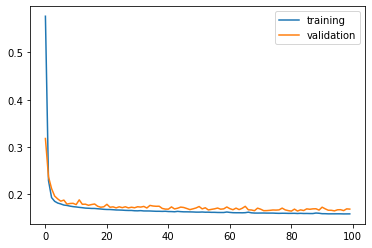

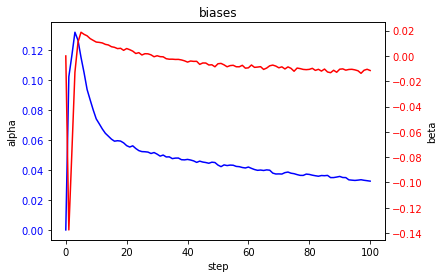

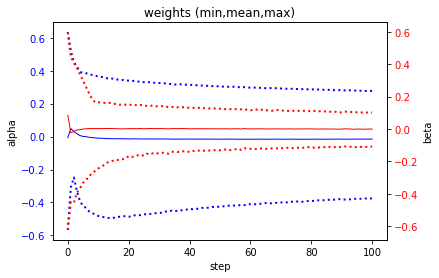

In [104]:
plt.plot(history.history['loss'],     label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()
weightwatcher.plot()

In [4503]:
#model.load_weights('./ltv_finish.wghts')

In [3995]:
# serialize model to JSON
'''model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5'''
'''model.save_weights("model.h5")
print("Saved model to disk")'''

'model.save_weights("model.h5")\nprint("Saved model to disk")'

In [4526]:
# load json and create model
'''json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./ltv_finish.wghts")
print("Loaded model from disk")'''

Loaded model from disk


### Предсказание с плотными матрицами

##### Предсказания для тренировочного набора

In [1710]:
y_train[:,:,0]

array([[ 5.        ,  4.        ,  3.        , ...,  4.77219034,
         4.77219034,  4.77219034],
       [13.        , 12.        , 11.        , ...,  2.        ,
         1.        ,  0.        ],
       [ 6.        ,  5.        ,  4.        , ...,  4.77219034,
         4.77219034,  4.77219034],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  4.77219034],
       [ 1.        ,  0.        ,  0.        , ...,  4.77219034,
         4.77219034,  4.77219034],
       [ 1.        ,  0.        ,  0.        , ...,  4.77219034,
         4.77219034,  4.77219034]])

In [196]:
# Make some predictions and put them alongside the real TTE and event indicator values
batch_size = 4096
train_predict = model.predict(x_train, batch_size=batch_size)

In [268]:
def weibull_pdf(alpha, beta, t):
    return (beta / alpha) * (t / alpha) ** (beta - 1) * np.exp(-(t / alpha) ** beta)

def weibull_median(alpha, beta):
    return alpha * (np.log(2)) ** (1 / beta)

def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1 / beta)

def weibull_mode(alpha, beta):
    assert np.all(beta > 1)
    return alpha * ((beta - 1) / beta) ** (1 / beta)

##### Предсказания для тестового набора

In [775]:
# Make some predictions and put them alongside the real TTE and event indicator values
batch_size = 2**14
test_predict = model.predict(x_test, batch_size=batch_size)

In [776]:
test_predict.shape,test_dataset_mod1.id.drop_duplicates().values.size

((72066, 23, 2), 72066)

In [777]:
# Преобразование предсказания для теста
test_pred_df = tr.padded_to_df(test_predict, ['alpha', 'beta'], ['float', 'float'],
                               ids=test_dataset_mod1.id.drop_duplicates().values, id_col='id', t_col='t_elapsed')
test_pred_df = test_dataset_mod1.merge(test_pred_df, on=['id', 't_elapsed'])

alpha 17.91392536675198 beta 1.1361958613864906


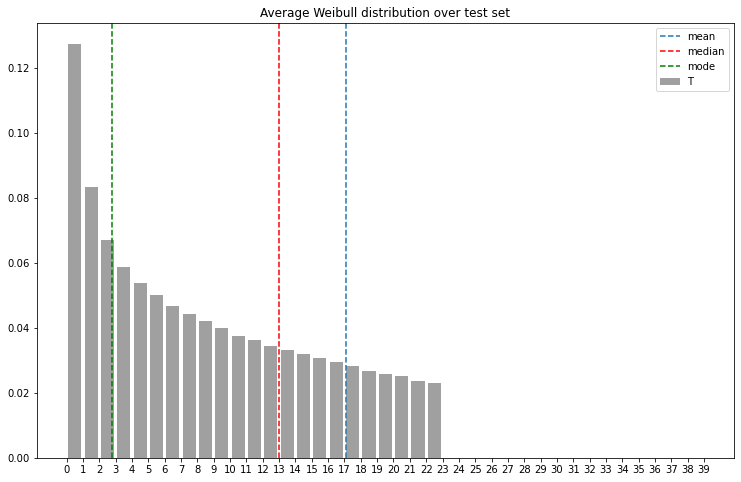

In [778]:
t = np.arange(0,40)
alpha = test_pred_df.loc[:, 'alpha'].mean()
beta = test_pred_df.loc[:, 'beta'].mean()

#plt.plot(t, weibull_pdf(alpha, beta, t))
mu = weibull_mean(alpha, beta)
median = weibull_median(alpha, beta)
mode = weibull_mode(alpha, beta)
plt.axvline(mu, ls='--', label='mean')
plt.axvline(median, ls='--', color='red', label='median')
plt.axvline(mode, ls='--', color='green', label='mode')
n, bins, patches = plt.hist(test_pred_df.loc[:, 'tte'], t,  facecolor='grey', density=True, alpha=0.75, label='T', rwidth= 0.8)
plt.xticks(np.arange(0, 40, 1))
plt.legend()

plt.gcf().set_size_inches(12.5, 8)
plt.title('Average Weibull distribution over test set')
print('alpha', alpha, 'beta', beta)

In [779]:
test_pred_df.loc[:, 'predicted_median'] = test_pred_df.loc[:, ['alpha', 'beta']]\
                            .apply(lambda row: weibull_median(row[0], row[1]), axis=1)

In [780]:
test_3m = test_pred_df.loc[(test_pred_df.t_elapsed >= 0) & (test_pred_df.cens == 1), :]

In [781]:
pred_col = 'predicted_median'
test_3m.loc[:, 'abs_error'] = (test_3m.loc[:, pred_col] - test_3m.tte).abs()
test_3m.loc[:, 'rate_error'] = test_3m.abs_error / (test_3m.cust_age + 1)

In [451]:
# средняя медианная ошибка на тестовой выборке
print('Median error: {}, Quantile 0.9: {}'.format(test_3m.abs_error.median(), test_3m.abs_error.quantile(q=0.90)))

Median error: 1.919636742694835, Quantile 0.9: 10.440666309936498


In [2066]:
n=1
print(test_pred_df[(test_pred_df['ddate']==datetime.date(2020,6,30)) & (test_pred_df['predicted_median']<n) & (test_pred_df['tte']<n) \
              ].shape[0]/test_pred_df[(test_pred_df['ddate']==datetime.date(2020,6,30)) & (test_pred_df['predicted_median']<n)\
                                                               ].shape[0],
test_pred_df[(test_pred_df['predicted_median']<=n) & (test_pred_df['tte']<n) &\
              (test_pred_df['ddate']==datetime.date(2020,6,30))].shape[0])

0.531437125748503 355


In [318]:
test_pred_df[test_pred_df['ddate']==datetime.date(2021,10,31)]['tte'].value_counts()

1    28510
0     2651
Name: tte, dtype: int64

In [2031]:
n=1
#test_pred_df['tte']
test_pred_df[(test_pred_df['ddate']==datetime.date(2020,11,30)) & (test_pred_df['predicted_median']<n)]['tte'].astype('int').describe()

count    1338.000000
mean        0.872197
std         0.908345
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: tte, dtype: float64

In [452]:
test_pred_df[test_pred_df['predicted_median']<2].shape
test_pred_df['predicted_median'].describe()

count    565376.000000
mean         12.261867
std          13.786597
min           0.037823
25%           3.569558
50%           8.935622
75%          17.471146
max         464.841633
Name: predicted_median, dtype: float64

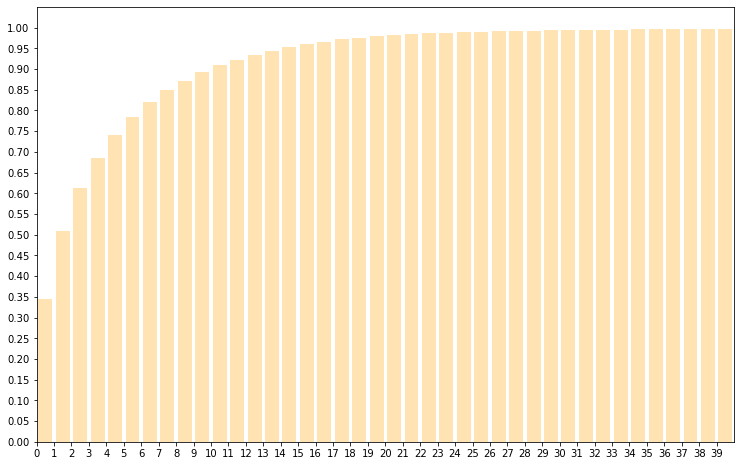

In [453]:
err_lim = 40
bars = np.arange(0, test_3m.abs_error.max(), 1)

v_bars = np.arange(0, err_lim, 1)
plt.xticks(v_bars)
plt.xlim([0, err_lim])
plt.yticks(np.arange(0, 1.05, 0.05))
plt.gcf().set_size_inches(12.5, 8)
test_err_p, _, _ = plt.hist(test_3m.abs_error, bars, cumulative=True, density=True, facecolor='orange', alpha=0.3, label='abs_error', rwidth=0.8)

In [454]:
print('S plot {}'.format(sum(test_err_p[:err_lim]) / err_lim))

S plot 0.9118760229911309


In [455]:
test_3m['tte'] = test_3m['tte'].astype('int')

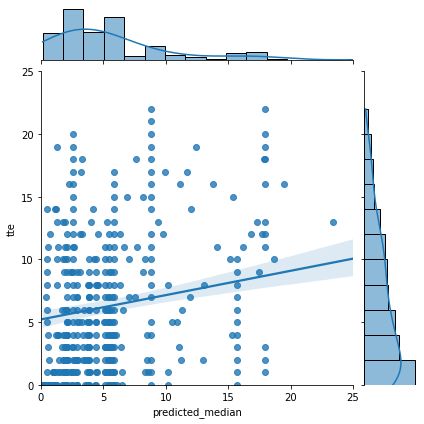

In [456]:
sns.jointplot(data=test_3m[2400:2800], y='tte', x='predicted_median', kind="reg", xlim=(0,25), ylim=(0,25))

In [457]:
# коэффициент конкордантности
lifelines.utils.concordance_index(test_3m.tte, test_3m.predicted_median)

0.7378935453174886

## Прогнозы

In [88]:
def weibull_pdf(alpha, beta, t):
    return (beta / alpha) * (t / alpha) ** (beta - 1) * np.exp(-(t / alpha) ** beta)

def weibull_median(alpha, beta):
    return alpha * (np.log(2)) ** (1 / beta)

def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1 / beta)

def weibull_mode(alpha, beta):
    assert np.all(beta > 1)
    return alpha * ((beta - 1) / beta) ** (1 / beta)

In [89]:
# загрузка весов обученной модели
model.load_weights('active_finish.wghts')

In [90]:
# добавляем столбцы для совместимости
# предсказываем для тех, кто еще жив на данный момент
dataset_forecast['tte'] = 0 # не знаем сколько еще осталось клиенту
dataset_forecast['cens'] = 0 # пока он живф

In [91]:
dataset_forecast1['ddate'] = dataset_forecast1['ddate'].apply(pd.to_datetime)
dataset_forecast1['ddate'] = dataset_forecast1['ddate'].map(lambda x: x.date())

In [92]:
mask_value = -100.0
#features_cols = cols_names

dataset_forecast1['t_elapsed'] = dataset_forecast1['t_elapsed'].astype(int)
if any(isinstance(t, pd.SparseDtype) for t in dataset_forecast1.dtypes):
    x_forecast = tr.df_to_padded(df=dataset_forecast1.sparse.to_dense(), column_names=features_cols, id_col='id',
                             t_col='t_elapsed')
else:
    x_forecast = tr.df_to_padded(df=dataset_forecast1, column_names=features_cols, id_col='id', t_col='t_elapsed')

x_forecast[:,:,:][np.isnan(x_forecast)] = mask_value

In [93]:
batch_size = 2**13
forecast_predict = model.predict(x_forecast, batch_size=batch_size)

forecast_pred_df = tr.padded_to_df(forecast_predict, ['alpha', 'beta'], ['float', 'float'],
                               ids=dataset_forecast1.id.drop_duplicates().values, id_col='id', t_col='t_elapsed')
forecast_pred_df = dataset_forecast1.loc[:, ['id', 'inn', 'ddate', 't_elapsed']]\
                                                            .merge(forecast_pred_df, on=['id', 't_elapsed'])

forecast_pred_df['pred_median_life'] = forecast_pred_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]),\
                                                                              axis=1)

In [94]:
forecast_pred_df['ddate'].max()

datetime.date(2023, 1, 31)

In [95]:
forecast_pred_df = forecast_pred_df.loc[forecast_pred_df.ddate == ddate, :]
forecast_pred_df = forecast_pred_df.rename(columns={'pred_month' : 'ddate'})
#forecast_pred_df = forecast_pred_df.loc[:, ['ddate', 'inn', 'pred_median_life']]

In [96]:
forecast_pred_df['pred_median_life'].describe()

count    149761.000000
mean         24.666725
std          17.505067
min           0.009276
25%          11.630863
50%          23.597882
75%          34.860246
max         340.562657
Name: pred_median_life, dtype: float64

In [97]:
table = pd.merge(forecast_pred_df,dataset_forecast[dataset_forecast.ddate == ddate][['inn','revenue_calc','cust_age']],on='inn')

In [98]:
# корректировка
table['pred_median_life'] = np.where(table['pred_median_life']> np.quantile(table['pred_median_life'],0.95),np.quantile(table['pred_median_life'],0.95),\
                                    table['pred_median_life']) 

In [99]:
# итоговое распределение времени жизни
table['pred_median_life'].describe()

count    149761.000000
mean         23.940565
std          15.162216
min           0.009276
25%          11.630863
50%          23.597882
75%          34.860246
max          53.467348
Name: pred_median_life, dtype: float64

In [100]:
np.quantile(forecast_pred_df['pred_median_life'],0.95)

53.46734782195602

In [101]:
# анализ выручки (для Антона)
def labeling_seven(x):
    if x<=5e6:
        return(0)
    elif x>5e6 and x<=2e7:
        return(1)
    elif x>2e7 and x<=9e7:
        return(2)
    elif x>9e7 and x<=4e8:
        return(3)
    elif x>4e8 and x<=3e9:
        return(4)  
    
table['rev'] = table['revenue_calc'].map(labeling_seven)
#table['pred_age'] = table['pred_median_life'] + table['cust_age']
table.groupby(['rev'])['pred_median_life'].median()

dataset_mod1['rev'] = dataset_mod1['revenue_calc'].map(labeling_seven)
#dataset_mod1['pred_age'] = dataset_mod1['pred_median_life'] + dataset_mod1['cust_age']
dataset_mod1.groupby(['rev'])['tte'].median()

rev
0.0    16.0
1.0    16.0
2.0    17.0
3.0    18.0
4.0    18.0
Name: tte, dtype: float64

In [102]:
table1 = table.loc[:,['ddate','inn','pred_median_life','rev','cust_age']]
table1['pred_median_life'] = table1['pred_median_life'].map(lambda x : np.round(x,0))
for i in ['cust_age','rev']:
    table1[i] = table1[i].fillna(-1)

In [103]:
# итоговая таблица с результатами прогноза
table1 = table1[['ddate','inn','pred_median_life']]
table1.head()

,ddate,inn,pred_median_life
0,2023-01-31,781701053605,34.0
1,2023-01-31,782616914647,36.0
2,2023-01-31,3666183017,14.0
3,2023-01-31,6162069832,39.0
4,2023-01-31,4632281610,41.0


In [104]:
import cx_Oracle

log = 'SHINKAREV_DA[PxU_DCBUL_UMA_MOD]'
pas = 'dSH_19848+++'
or_tns = 'DATALAB'

tns = or_tns
conn = cx_Oracle.connect(log, pas, tns)
c = conn.cursor()

c.executemany('insert into zay_ltv_results (pred_month,inn,pred_median_life) values (:1,:2,:3)',list(table1.values))     
conn.commit()